In [5]:
pip install factor_analyzer

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42715 sha256=1c384ded840af33fe60366127f01567966deaf80ce2d23c2aa706c7c7a8df272
  Stored in directory: c:\users\david\appdata\local\pip\cache\wheels\87\6e\8f\914f20e0242ee0214e5c8336031a2fab12e632e4695fbb7276
Successfully built factor_analyzer
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, RocCurveDisplay, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, silhouette_score, adjusted_rand_score


## Punto 1 ##

Las variables significativas obtenidas de la base de datos "diabetes" son:

pregnancies, glucose, blood pressure, skin thickness y BMI

In [2]:
df_csv = pd.read_csv("diabetes.csv")
df_csv

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


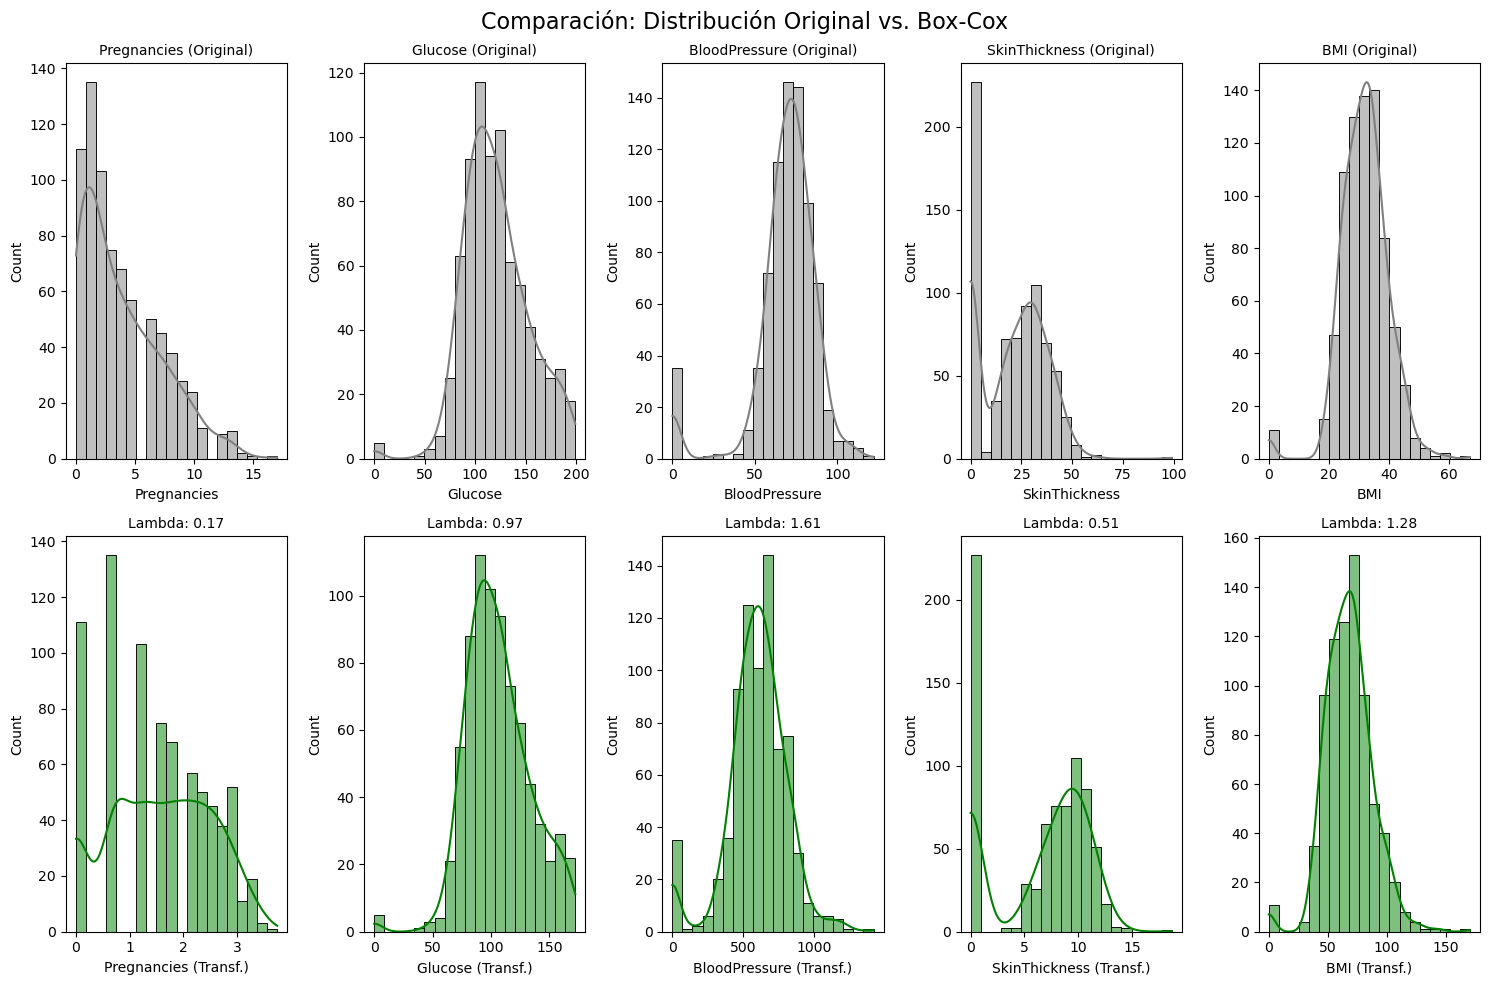

Valores de Lambda óptimos encontrados:
Pregnancies: 0.1727
Glucose: 0.9664
BloodPressure: 1.6066
SkinThickness: 0.5116
BMI: 1.2766


In [3]:
# --- TRANSFORMACIÓN DE BOX-COX ---
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Seleccionamos las variables cuantitativas significativas
# Excluímos 'Outcome' porque es categórica
vars_a_transformar = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

# Creamos una copia para no dañar el dataframe original
df_boxcox = df_csv.copy()

# Diccionario para guardar los valores de lambda (útil para tu reporte)
lambdas = {}

# 2. Aplicamos Box-Cox
plt.figure(figsize=(15, 10))

for i, col in enumerate(vars_a_transformar):
    # Box-Cox requiere datos > 0. 
    # Sumamos 1 a toda la columna para manejar los ceros (shift)
    data_shifted = df_boxcox[col] + 1
    
    # Aplicamos la función
    # retorna: (datos_transformados, lambda_optimo)
    datos_trans, best_lambda = stats.boxcox(data_shifted)
    
    # Guardamos en el nuevo dataframe
    df_boxcox[col + '_boxcox'] = datos_trans
    lambdas[col] = best_lambda
    
    # --- GRÁFICOS COMPARATIVOS (ANTES vs DESPUÉS) ---
    # Fila superior: Originales | Fila inferior: Transformados
    
    # Histograma Original
    plt.subplot(2, 5, i+1)
    sns.histplot(df_csv[col], kde=True, color='gray', bins=20)
    plt.title(f'{col} (Original)', fontsize=10)
    
    # Histograma Box-Cox
    plt.subplot(2, 5, i+6)
    sns.histplot(datos_trans, kde=True, color='green', bins=20)
    plt.title(f'Lambda: {best_lambda:.2f}', fontsize=10)
    plt.xlabel(f'{col} (Transf.)')

plt.suptitle('Comparación: Distribución Original vs. Box-Cox', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Mostrar los Lambdas óptimos (para tu análisis escrito)
print("Valores de Lambda óptimos encontrados:")
for col, lmbda in lambdas.items():
    print(f"{col}: {lmbda:.4f}")

In [4]:
df_boxcox

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_boxcox,Glucose_boxcox,BloodPressure_boxcox,SkinThickness_boxcox,BMI_boxcox
0,6,148,72,35,0,33.6,0.627,50,1,2.312860,129.287472,612.796085,10.270251,71.441945
1,1,85,66,29,0,26.6,0.351,31,0,0.736347,75.586530,533.834829,9.181587,53.338498
2,8,183,64,0,0,23.3,0.672,32,1,2.672316,158.763367,508.435711,0.000000,45.218459
3,1,89,66,23,94,28.1,0.167,21,0,0.736347,79.027936,533.834829,7.980214,57.121254
4,0,137,40,35,168,43.1,2.288,33,1,0.000000,119.977756,242.168827,10.270251,97.661167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,2.970752,89.322222,667.689327,12.358706,69.581863
764,2,122,70,27,0,36.8,0.340,27,0,1.209765,107.241987,586.020252,8.795390,80.075864
765,5,121,72,23,112,26.2,0.245,30,0,2.099975,106.391146,612.796085,7.980214,52.339205
766,1,126,60,0,0,30.1,0.349,47,1,0.736347,110.643049,459.052517,0.000000,62.249109


In [5]:
print("Creando la columna cualitativa 'Grupo_Edad'...")

# Definimos los límites (bins) para los grupos de edad:
bins = [0, 30, 50, np.inf]

# Definimos las etiquetas (nombres) para esos grupos
labels = ['Joven (0-30)', 'Adulto (31-50)', 'Mayor (51+)']

# Usamos la función pd.cut() para crear la nueva columna
# Asegúrate de que tu archivo tenga una columna llamada 'Age'
df_csv['Grupo_Edad'] = pd.cut(df_csv['Age'], bins=bins, labels=labels, right=True)

print("--- DataFrame Modificado (con la nueva columna 'Grupo_Edad') ---")
print(df_csv.head())

# Verificamos los tipos de datos (dtypes) para confirmar
print("\n--- Tipos de Datos (Dtypes) ---")
print(df_csv.dtypes)

Creando la columna cualitativa 'Grupo_Edad'...
--- DataFrame Modificado (con la nueva columna 'Grupo_Edad') ---
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome      Grupo_Edad  
0                     0.627   50        1  Adulto (31-50)  
1                     0.351   31        0  Adulto (31-50)  
2                     0.672   32        1  Adulto (31-50)  
3                     0.167   21        0    Joven (0-30)  
4                     2.288   33        1  Adulto (31-50)  

--- Tipos de Datos (Dtypes) ---
Pregnancies                    int64
Glucose                  

In [6]:
df_csv

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Grupo_Edad
0,6,148,72,35,0,33.6,0.627,50,1,Adulto (31-50)
1,1,85,66,29,0,26.6,0.351,31,0,Adulto (31-50)
2,8,183,64,0,0,23.3,0.672,32,1,Adulto (31-50)
3,1,89,66,23,94,28.1,0.167,21,0,Joven (0-30)
4,0,137,40,35,168,43.1,2.288,33,1,Adulto (31-50)
...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,Mayor (51+)
764,2,122,70,27,0,36.8,0.340,27,0,Joven (0-30)
765,5,121,72,23,112,26.2,0.245,30,0,Joven (0-30)
766,1,126,60,0,0,30.1,0.349,47,1,Adulto (31-50)


C:\Users\david\AppData\Local\Temp\ipykernel_12256\2858297853.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxcox, x='Outcome', y=var, palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_12256\2858297853.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxcox, x='Outcome', y=var, palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_12256\2858297853.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_boxcox, x='Outcome', y=var, palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_12256

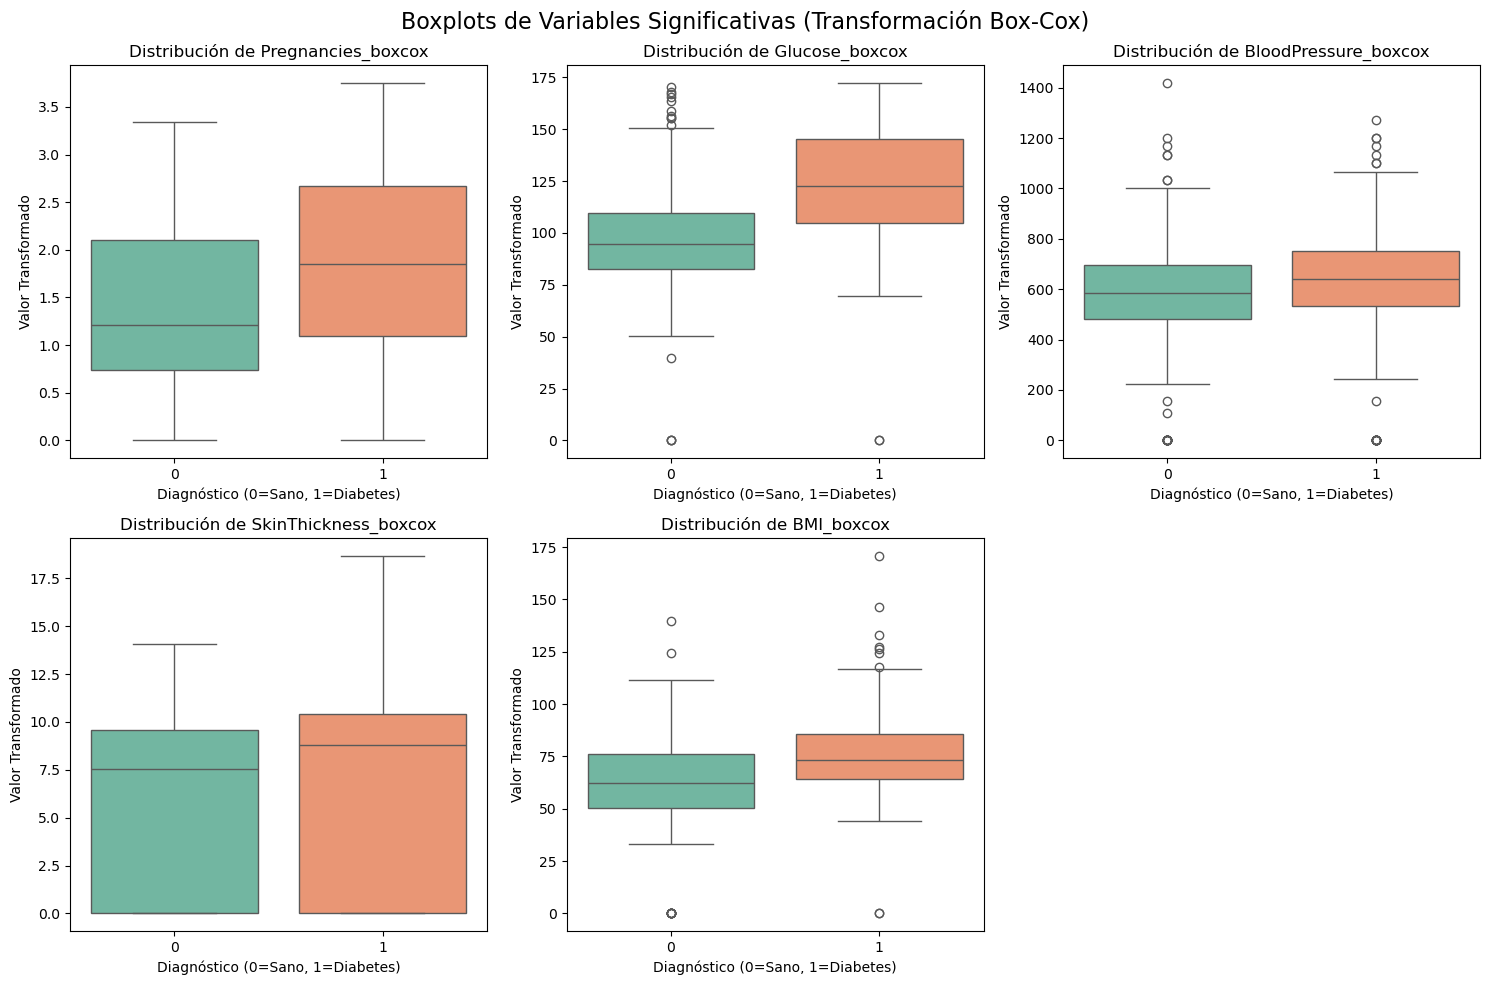

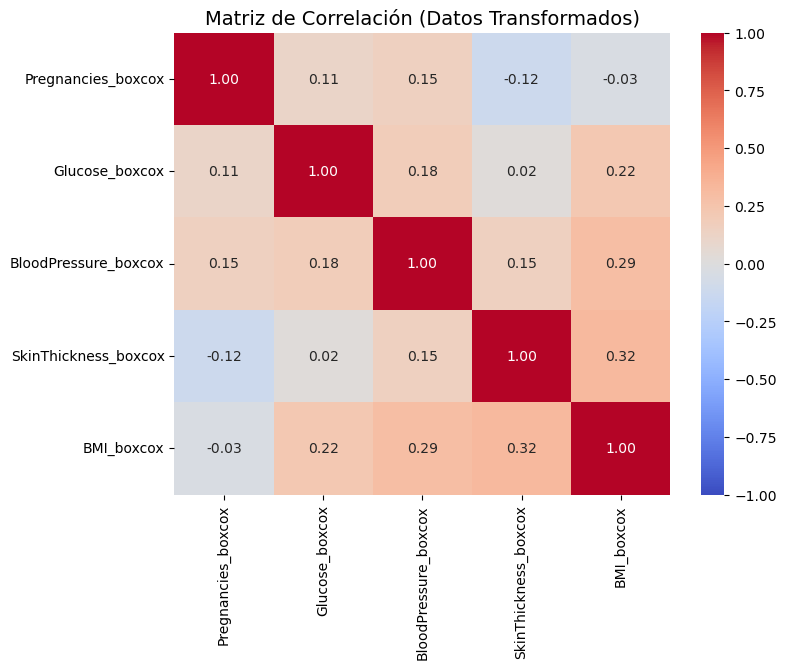

In [7]:
# 1. Definimos la lista de las nuevas variables (las que terminan en _boxcox)
# Asegúrate de usar los mismos nombres que generamos en el paso anterior
vars_boxcox = ['Pregnancies_boxcox', 'Glucose_boxcox', 'BloodPressure_boxcox', 
               'SkinThickness_boxcox', 'BMI_boxcox']

# --- PARTE A: BOXPLOTS (Distribución según Outcome) ---
plt.figure(figsize=(15, 10))

for i, var in enumerate(vars_boxcox):
    plt.subplot(2, 3, i+1) # Configura una grilla de gráficos
    
    # Creamos el boxplot
    sns.boxplot(data=df_boxcox, x='Outcome', y=var, palette='Set2')
    
    # Estética
    plt.title(f'Distribución de {var}', fontsize=12)
    plt.xlabel('Diagnóstico (0=Sano, 1=Diabetes)')
    plt.ylabel('Valor Transformado')

plt.suptitle('Boxplots de Variables Significativas (Transformación Box-Cox)', fontsize=16)
plt.tight_layout()
plt.show()

# --- PARTE B: MATRIZ DE CORRELACIÓN (Box-Cox) ---
plt.figure(figsize=(8, 6))

# Calculamos la correlación solo de las variables transformadas
matriz_corr_boxcox = df_boxcox[vars_boxcox].corr()

# Graficamos el Heatmap
sns.heatmap(matriz_corr_boxcox, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación (Datos Transformados)', fontsize=14)
plt.show()

## NO SÉ SI GRUPO EDAD ES SIGNIFICATIVA ##

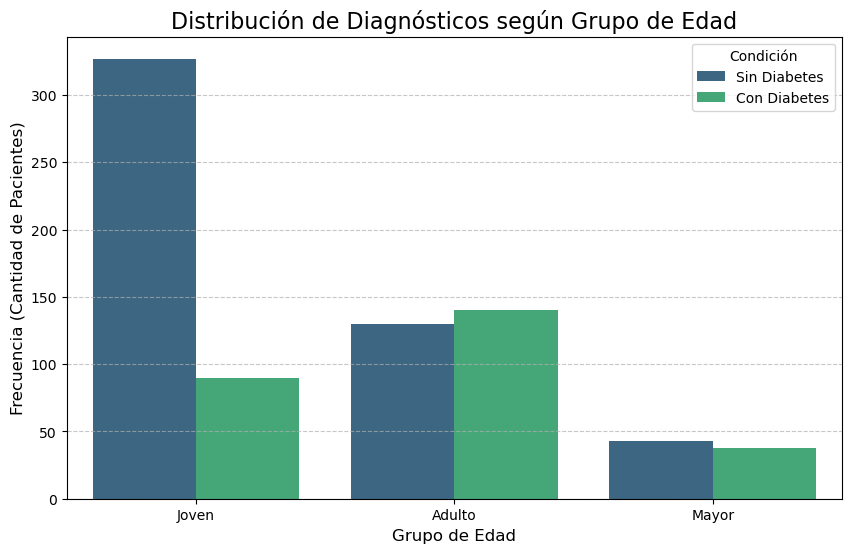

In [8]:
# 1. Asegurémonos de tener la variable creada (si ya la tienes, puedes omitir esta línea)
# Ajusta los bins (cortes de edad) si usaste otros rangos diferentes
bins = [0, 30, 50, 100] 
labels = ['Joven', 'Adulto', 'Mayor']
df_csv['Grupo_Edad'] = pd.cut(df_csv['Age'], bins=bins, labels=labels)

# 2. Configuración del gráfico
plt.figure(figsize=(10, 6))

# Creamos el gráfico de barras (countplot)
# 'hue' nos permite separar las barras por el diagnóstico de diabetes
sns.countplot(data=df_csv, x='Grupo_Edad', hue='Outcome', palette='viridis')

# 3. Personalización para que se vea profesional en el artículo
plt.title('Distribución de Diagnósticos según Grupo de Edad', fontsize=16)
plt.xlabel('Grupo de Edad', fontsize=12)
plt.ylabel('Frecuencia (Cantidad de Pacientes)', fontsize=12)

# Ajustar la leyenda para que no diga 0 y 1, sino algo legible
plt.legend(title='Condición', labels=['Sin Diabetes', 'Con Diabetes'])

# Mostrar el gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7) # Agrega líneas de guía suaves
plt.show()

In [9]:
def analizar_multicolinealidad(df, variables_significativas, umbral=0.8):
    """
    df: DataFrame original
    variables_significativas: lista de variables cuantitativas ya filtradas en el punto 1
    umbral: correlación absoluta para eliminar variables (default = 0.8)
    """

    # 1. Subset solo con variables significativas
    df_sub = df[variables_significativas]

    # 2. Matriz de correlación
    corr_matrix = df_sub.corr()

    # 3. Plot de la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de Correlación (Variables Significativas)")
    plt.show()

    # 4. Buscar pares de alta correlación
    altas_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) >= umbral:
                altas_corr.append((
                    corr_matrix.index[i],
                    corr_matrix.columns[j],
                    round(corr_val, 4)
                ))

    # 5. Decidir variables a eliminar (tomar la segunda del par)
    variables_eliminar = list({par[0] for par in altas_corr})

    # 6. Variables finales sin multicolinealidad
    variables_finales = [v for v in variables_significativas if v not in variables_eliminar]

    # 7. Resultados
    resultados = {
        "Matriz de correlación": corr_matrix,
        "Pares con alta correlación (>|{}|)".format(umbral): altas_corr,
        "Variables eliminadas": variables_eliminar if len(variables_eliminar) > 0 else "Ninguna",
        "Variables finales": variables_finales
    }

    return resultados

## NO PUEDO USAR GRUPO EDAD EN MATRIZ PQ ES STRING ##

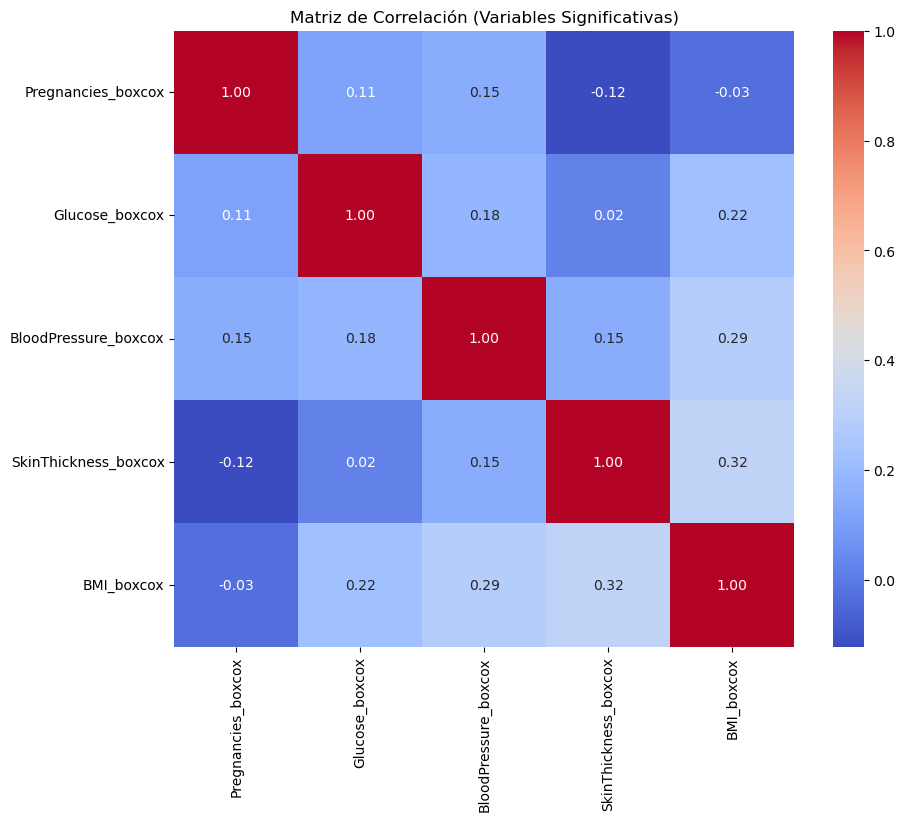


--- Matriz de correlación ---
                      Pregnancies_boxcox  Glucose_boxcox  \
Pregnancies_boxcox              1.000000        0.113381   
Glucose_boxcox                  0.113381        1.000000   
BloodPressure_boxcox            0.149301        0.182515   
SkinThickness_boxcox           -0.121442        0.019166   
BMI_boxcox                     -0.031566        0.221893   

                      BloodPressure_boxcox  SkinThickness_boxcox  BMI_boxcox  
Pregnancies_boxcox                0.149301             -0.121442   -0.031566  
Glucose_boxcox                    0.182515              0.019166    0.221893  
BloodPressure_boxcox              1.000000              0.149508    0.289899  
SkinThickness_boxcox              0.149508              1.000000    0.323449  
BMI_boxcox                        0.289899              0.323449    1.000000  

--- Pares con alta correlación (>|0.8|) ---
[]

--- Variables eliminadas ---
Ninguna

--- Variables finales ---
['Pregnancies_boxcox'

In [10]:
variables_significativas = ['Pregnancies_boxcox', 'Glucose_boxcox', 'BloodPressure_boxcox', 
               'SkinThickness_boxcox', 'BMI_boxcox']
res = analizar_multicolinealidad(df_boxcox, variables_significativas)

for k, v in res.items():
    print("\n---", k, "---")
    print(v)

df_sub = df_boxcox[variables_significativas]

# 2. Matriz de correlación
corr_matrix = df_sub.corr()
"""Creates a table of highly correlated variables based on the threshold."""
threshold = 0.5
correlated_vars = (round(corr_matrix.abs(),1) >= threshold).sum() - 1  # Exclude self-correlation
correlated_table = pd.DataFrame({
         "Variable": correlated_vars.index,
        f"Correlated Variables (≥ {threshold:.1f})": correlated_vars.values
    })

correlated_table["PCA Candidate"] = correlated_table.iloc[:, 1] > 0
        
print(f"\nCorrelated Variables Table:")
print(correlated_table.to_string(index=False))

## PUNTO 2 ##

Explained variance ratio: [0.32468446 0.24033237 0.17192877 0.14265396 0.12040043]
Cumulative Explained variance ratio: [0.32468446 0.56501683 0.73694561 0.87959957 1.        ]


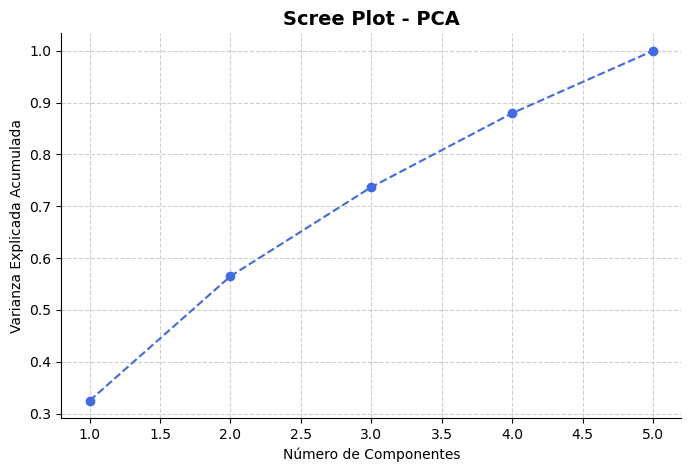

In [11]:

# 1. Estandarizar los datos (Paso Crucial)
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(df_boxcox[vars_boxcox])

# 2. Aplicar PCA a los datos escalados
pca = PCA()
principal_components = pca.fit_transform(datos_escalados)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative Explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

explained_variance = pca.explained_variance_ratio_

num_components = np.arange(1, len(explained_variance) + 1) 

plt.figure(figsize=(8, 5))
plt.plot(num_components,np.cumsum(explained_variance), marker="o", linestyle="--", color="royalblue")
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Scree Plot - PCA", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
sns.despine()
plt.show()

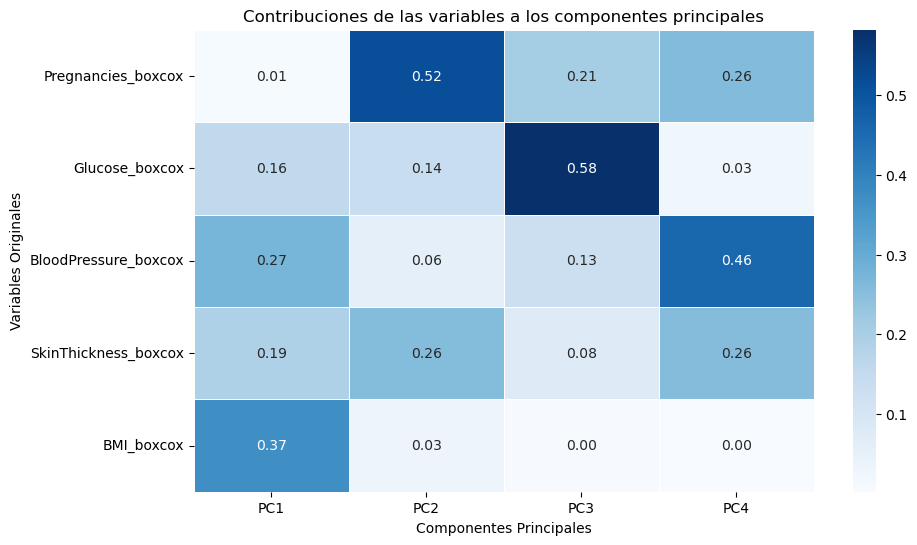

In [12]:
# Crear un nuevo Data Frame con los valores de PC
num_pcs = 4
pc_columns = [f"PC{i+1}" for i in range(num_pcs)]
df_pca = pd.DataFrame(principal_components[:, :num_pcs], columns=pc_columns, index=df_boxcox.index)


df_final = pd.concat([df_boxcox, df_pca], axis=1)
df_final = df_final.reset_index(drop=True)

# Contribución de los componentes principales
# Cada variable contribuye en distinta medida a cada componente principal.
# El cálculo que realizamos muestra qué porcentaje aporta cada variable dentro de un componente.
# Por ejemplo, si la variable "edad" aporta 0.5 en el PC1, significa que explica el 50% de la información de ese componente.
# La suma de todas las contribuciones para un mismo componente es 100% (o 1 en proporción),
# porque el componente está formado por la combinación de todas las variables.
loadings = pca.components_  # Loadings (eigenvectors)
contributions = (loadings**2) / np.sum(loadings**2, axis=1, keepdims=True)   # Contributions 

contributions_df = pd.DataFrame(contributions.T, index=variables_significativas, columns=[f"PC{i+1}" for i in range(contributions.shape[0])])
contributions_to_plot = contributions_df.iloc[:, :num_pcs]

plt.figure(figsize=(10, 6))
sns.heatmap(contributions_to_plot, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.xlabel("Componentes Principales")
plt.ylabel("Variables Originales")
plt.title("Contribuciones de las variables a los componentes principales")
plt.show()

In [13]:
display(df_final)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_boxcox,Glucose_boxcox,BloodPressure_boxcox,SkinThickness_boxcox,BMI_boxcox,PC1,PC2,PC3,PC4
0,6,148,72,35,0,33.6,0.627,50,1,2.312860,129.287472,612.796085,10.270251,71.441945,0.929610,0.440034,0.024188,-0.953980
1,1,85,66,29,0,26.6,0.351,31,0,0.736347,75.586530,533.834829,9.181587,53.338498,-0.840403,-1.281358,-0.592061,0.110570
2,8,183,64,0,0,23.3,0.672,32,1,2.672316,158.763367,508.435711,0.000000,45.218459,-0.669756,2.400516,1.401155,-0.428304
3,1,89,66,23,94,28.1,0.167,21,0,0.736347,79.027936,533.834829,7.980214,57.121254,-0.793807,-1.130688,-0.408245,0.217965
4,0,137,40,35,168,43.1,2.288,33,1,0.000000,119.977756,242.168827,10.270251,97.661167,0.465285,-2.070519,1.589632,-0.924240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,2.970752,89.322222,667.689327,12.358706,69.581863,0.687441,0.226488,-1.637934,-1.124095
764,2,122,70,27,0,36.8,0.340,27,0,1.209765,107.241987,586.020252,8.795390,80.075864,0.562510,-0.627425,0.097650,-0.176971
765,5,121,72,23,112,26.2,0.245,30,0,2.099975,106.391146,612.796085,7.980214,52.339205,-0.225265,0.397692,-0.441514,-0.402190
766,1,126,60,0,0,30.1,0.349,47,1,0.736347,110.643049,459.052517,0.000000,62.249109,-1.146821,0.083337,1.116665,0.685079


## PUNTO 4 ##


Precisión del Modelo (Box-Cox): 0.71

--- Reporte de Clasificación (Box-Cox) ---
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       151
           1       0.60      0.53      0.56        80

    accuracy                           0.71       231
   macro avg       0.68      0.67      0.67       231
weighted avg       0.71      0.71      0.71       231



<Figure size 600x500 with 0 Axes>

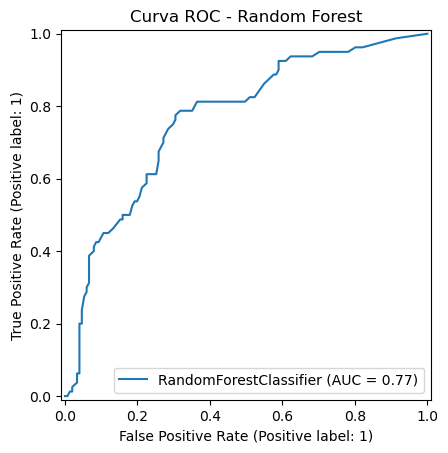

C:\Users\david\AppData\Local\Temp\ipykernel_12256\1819701781.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=df_importancia, palette='viridis', ax=axes[1])


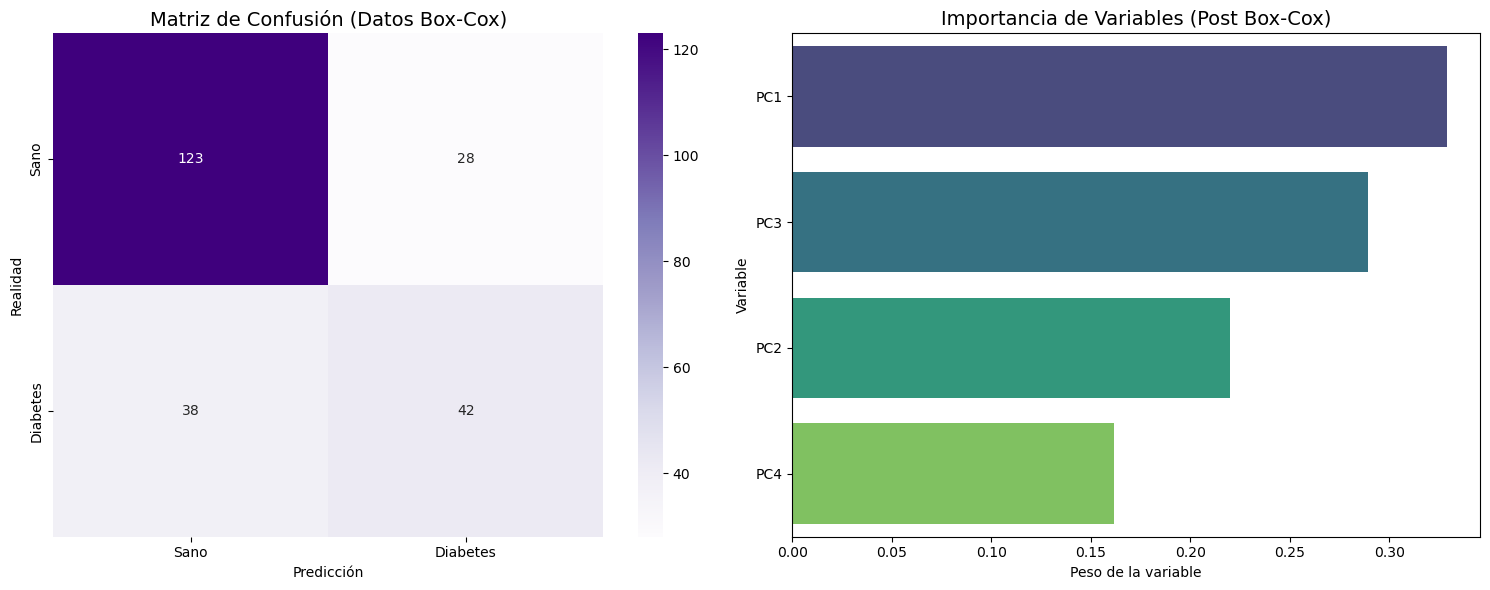

In [19]:
# --- PUNTO 4: MODELO DE CLASIFICACIÓN (Random Forest) ---
# 1. Preparación de los datos
# Usamos las variables transformadas (_boxcox)
vars_boxcox = ['PC1', 'PC2', 'PC3', 'PC4',]

X = df_final[vars_boxcox]
y = df_final['Outcome']

# División 70% entrenamiento, 30% prueba (misma semilla 'random_state=42' para ser comparables)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Entrenamiento del Modelo
rf_boxcox_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_boxcox_model.fit(X_train, y_train)

# 3. Predicciones
y_pred_boxcox = rf_boxcox_model.predict(X_test)

# --- RESULTADOS ---

# A. Métricas Numéricas
acc_boxcox = accuracy_score(y_test, y_pred_boxcox)
print(f"Precisión del Modelo (Box-Cox): {acc_boxcox:.2f}")
print("\n--- Reporte de Clasificación (Box-Cox) ---")
print(classification_report(y_test, y_pred_boxcox))

# Curva ROC
# ------------------------------------------------------------
plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(rf_boxcox_model, X_test, y_test)
plt.title("Curva ROC - Random Forest")
plt.show()

# B. Gráficos Comparativos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_boxcox)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0],
            xticklabels=['Sano', 'Diabetes'], yticklabels=['Sano', 'Diabetes'])
axes[0].set_title('Matriz de Confusión (Datos Box-Cox)', fontsize=14)
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Realidad')

# Gráfico 2: Importancia de las Variables
importancias = rf_boxcox_model.feature_importances_
df_importancia = pd.DataFrame({'Variable': vars_boxcox, 'Importancia': importancias})
df_importancia = df_importancia.sort_values('Importancia', ascending=False)

sns.barplot(x='Importancia', y='Variable', data=df_importancia, palette='viridis', ax=axes[1])
axes[1].set_title('Importancia de Variables (Post Box-Cox)', fontsize=14)
axes[1].set_xlabel('Peso de la variable')

plt.tight_layout()
plt.show()

## PUNTO 5 ##

c:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


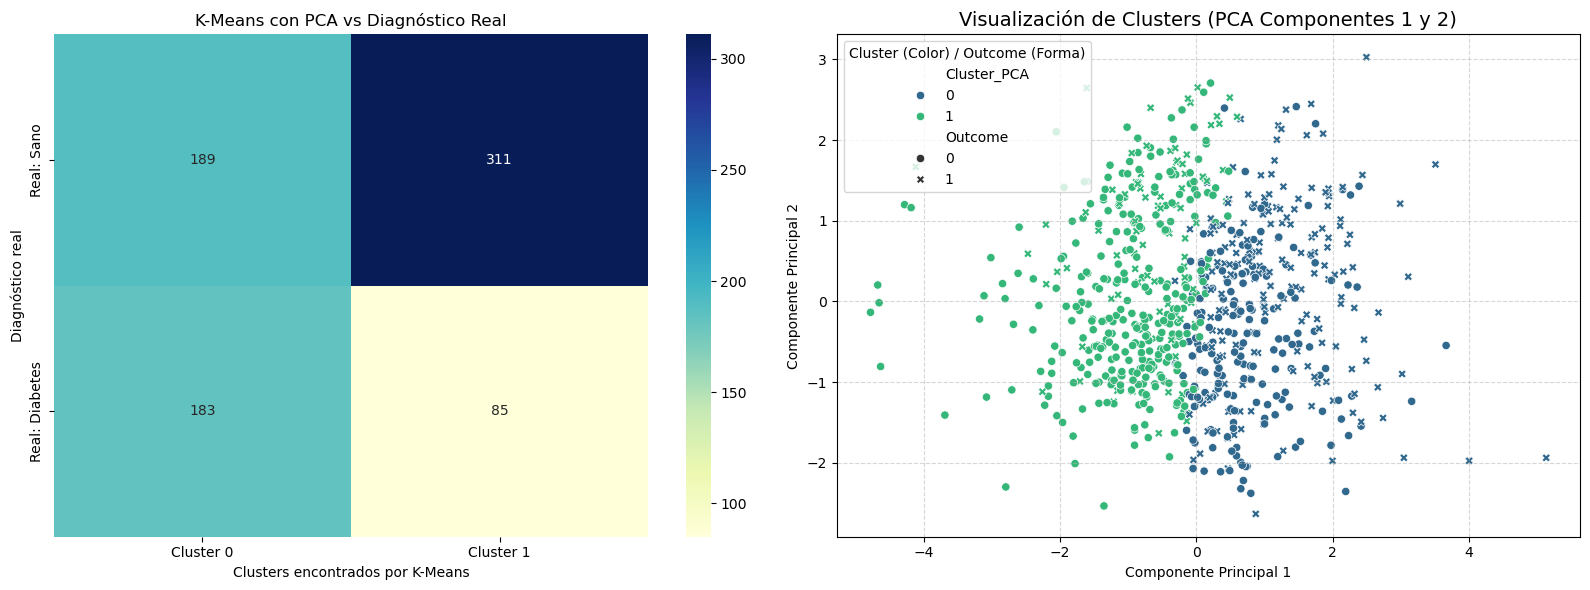

c:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


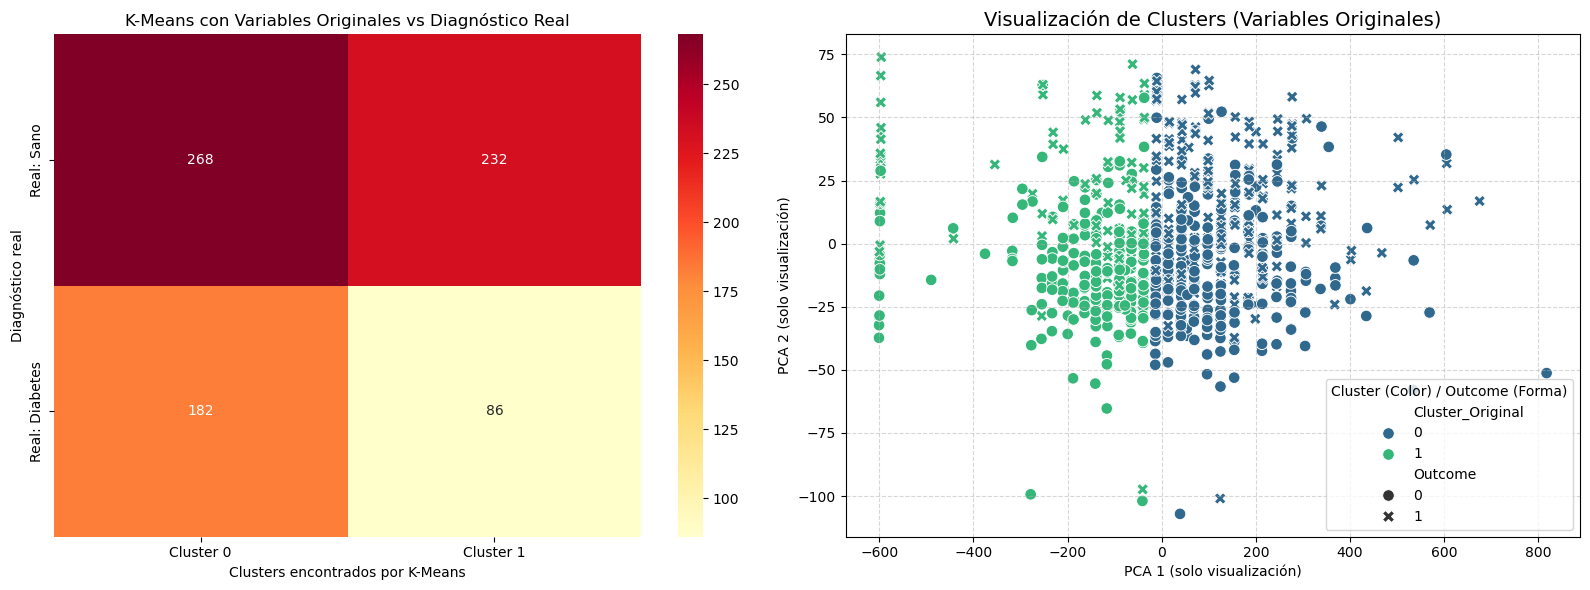

 COMPARACIÓN ENTRE PCA Y VARIABLES ORIGINALES
Silhouette Score (PCA): 0.1868
Silhouette Score (Originales): 0.4725
-------------------------------------------------
ARI (PCA vs Outcome): 0.0809
ARI (Originales vs Outcome): 0.0023


In [31]:
# ============================================================
#   1. K-MEANS CON PCA
# ============================================================

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_pca = kmeans.fit_predict(principal_components)

df_csv['Cluster_PCA'] = clusters_pca

# Matriz de confusión PCA
cm_pca = confusion_matrix(df_csv['Outcome'], df_csv['Cluster_PCA'])

# -------- FIGURA 1: MATRIZ + VISUALIZACIÓN PCA ----------------
plt.figure(figsize=(16, 6))

# ----- Subplot 1: Matriz de confusión PCA -----
plt.subplot(1, 2, 1)
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Real: Sano', 'Real: Diabetes'])
plt.title('K-Means con PCA vs Diagnóstico Real')
plt.xlabel('Clusters encontrados por K-Means')
plt.ylabel('Diagnóstico real')

# ----- Subplot 2: Visualización PCA -----
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=df_csv['Cluster_PCA'],
    palette='viridis',
    style=df_csv['Outcome']
)
plt.title("Visualización de Clusters (PCA Componentes 1 y 2)", fontsize=14)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster (Color) / Outcome (Forma)")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()



# ============================================================
#   2. K-MEANS CON VARIABLES ORIGINALES (Box-Cox)
# ============================================================

X_original = df_boxcox[variables_significativas]

kmeans_orig = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_orig = kmeans_orig.fit_predict(X_original)

df_csv['Cluster_Original'] = clusters_orig

cm_orig = confusion_matrix(df_csv['Outcome'], df_csv['Cluster_Original'])

# ------ PCA para visualizar los datos originales --------
pca_vis = PCA(n_components=2)
original_2d = pca_vis.fit_transform(X_original)

# -------- FIGURA 2: MATRIZ + VISUALIZACIÓN ORIGINALES -------
plt.figure(figsize=(16, 6))

# ----- Subplot 1: Matriz de confusión Originales -----
plt.subplot(1, 2, 1)
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Real: Sano', 'Real: Diabetes'])
plt.title('K-Means con Variables Originales vs Diagnóstico Real')
plt.xlabel('Clusters encontrados por K-Means')
plt.ylabel('Diagnóstico real')

# ----- Subplot 2: Visualización Originales -----
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=original_2d[:, 0],
    y=original_2d[:, 1],
    hue=df_csv['Cluster_Original'],
    style=df_csv['Outcome'],
    palette='viridis',
    s=70
)
plt.title("Visualización de Clusters (Variables Originales)", fontsize=14)
plt.xlabel("PCA 1 (solo visualización)")
plt.ylabel("PCA 2 (solo visualización)")
plt.legend(title="Cluster (Color) / Outcome (Forma)")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



# ============================================================
#   3. COMPARACIÓN CUANTITATIVA
# ============================================================

sil_pca = silhouette_score(principal_components, df_csv['Cluster_PCA'])
sil_orig = silhouette_score(X_original, df_csv['Cluster_Original'])

ari_pca = adjusted_rand_score(df_csv['Outcome'], df_csv['Cluster_PCA'])
ari_orig = adjusted_rand_score(df_csv['Outcome'], df_csv['Cluster_Original'])

print("=================================================")
print(" COMPARACIÓN ENTRE PCA Y VARIABLES ORIGINALES")
print("=================================================")
print(f"Silhouette Score (PCA): {sil_pca:.4f}")
print(f"Silhouette Score (Originales): {sil_orig:.4f}")
print("-------------------------------------------------")
print(f"ARI (PCA vs Outcome): {ari_pca:.4f}")
print(f"ARI (Originales vs Outcome): {ari_orig:.4f}")
print("=================================================")
